In [34]:
using Pkg
Pkg.activate("climate"; shared=true)

"/Users/imolk/Library/Julia/environments/climate/Project.toml"

$$
    \newcommand{\genericdel}[3]{%
      \left#1#3\right#2
    }
    \newcommand{\del}[1]{\genericdel(){#1}}
    \newcommand{\sbr}[1]{\genericdel[]{#1}}
    \newcommand{\cbr}[1]{\genericdel\{\}{#1}}
    \newcommand{\abs}[1]{\genericdel||{#1}}
    \DeclareMathOperator*{\argmin}{arg\,min}
    \DeclareMathOperator*{\argmax}{arg\,max}
    \DeclareMathOperator{\Pr}{\mathbb{p}}
    \DeclareMathOperator{\E}{\mathbb{E}}
    \DeclareMathOperator{\Ind}{\mathbb{I}}
    \DeclareMathOperator{\var}{var}
    \DeclareMathOperator{\cov}{cov}
    \DeclareMathOperator{\invchi}{\mathrm{Inv-\chi}^2}
    \DeclareMathOperator*{\argmin}{arg\,min}
    \DeclareMathOperator*{\argmax}{arg\,max}
    \newcommand{\effect}{\mathrm{eff}}
    \newcommand{\xtilde}{\widetilde{X}}
    \DeclareMathOperator{\normal}{\mathcal{N}}
    \DeclareMathOperator{\unif}{Uniform}
    \DeclareMathOperator{\GP}{\mathcal{GP}}
    \DeclareMathOperator{\l}{\mathscr{l}}
    \newcommand{\Tn}{\mathrm{T}_{n}}
    \newcommand{\Tx}{\mathrm{T}_{x}}
$$

Build the pipeline to get the data into STAN.

In [35]:
using CmdStan
using Printf
using TimeSeries
using DataFrames
using GaussianProcesses
using GaussianProcesses: Mean, Kernel, evaluate, metric, IsotropicData, VecF64
using GaussianProcesses: Stationary, KernelData, MatF64, predict
import GaussianProcesses: optimize!, get_optim_target, cov, grad_slice!
import GaussianProcesses: num_params, set_params!, get_params, update_mll!, update_mll_and_dmll!
import GaussianProcesses: get_param_names, cov!
import Proj4
using Optim
using Distances
using DataFrames: by, head
using Dates: tonext, Hour, Day
using Distributions
using LinearAlgebra: eye, diag
;

In [36]:
import PyPlot; plt=PyPlot
using LaTeXStrings
plt.rc("figure", dpi=300.0)
plt.rc("figure", figsize=(12,8))
plt.rc("savefig", dpi=300.0)
plt.rc("text", usetex=true)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
;

# Data import and preprocessing

In [37]:
include("iowa.jl")
iowa = prepare_iowa_data(data_dir);

# Visualizing Test Data: Tn and Tx

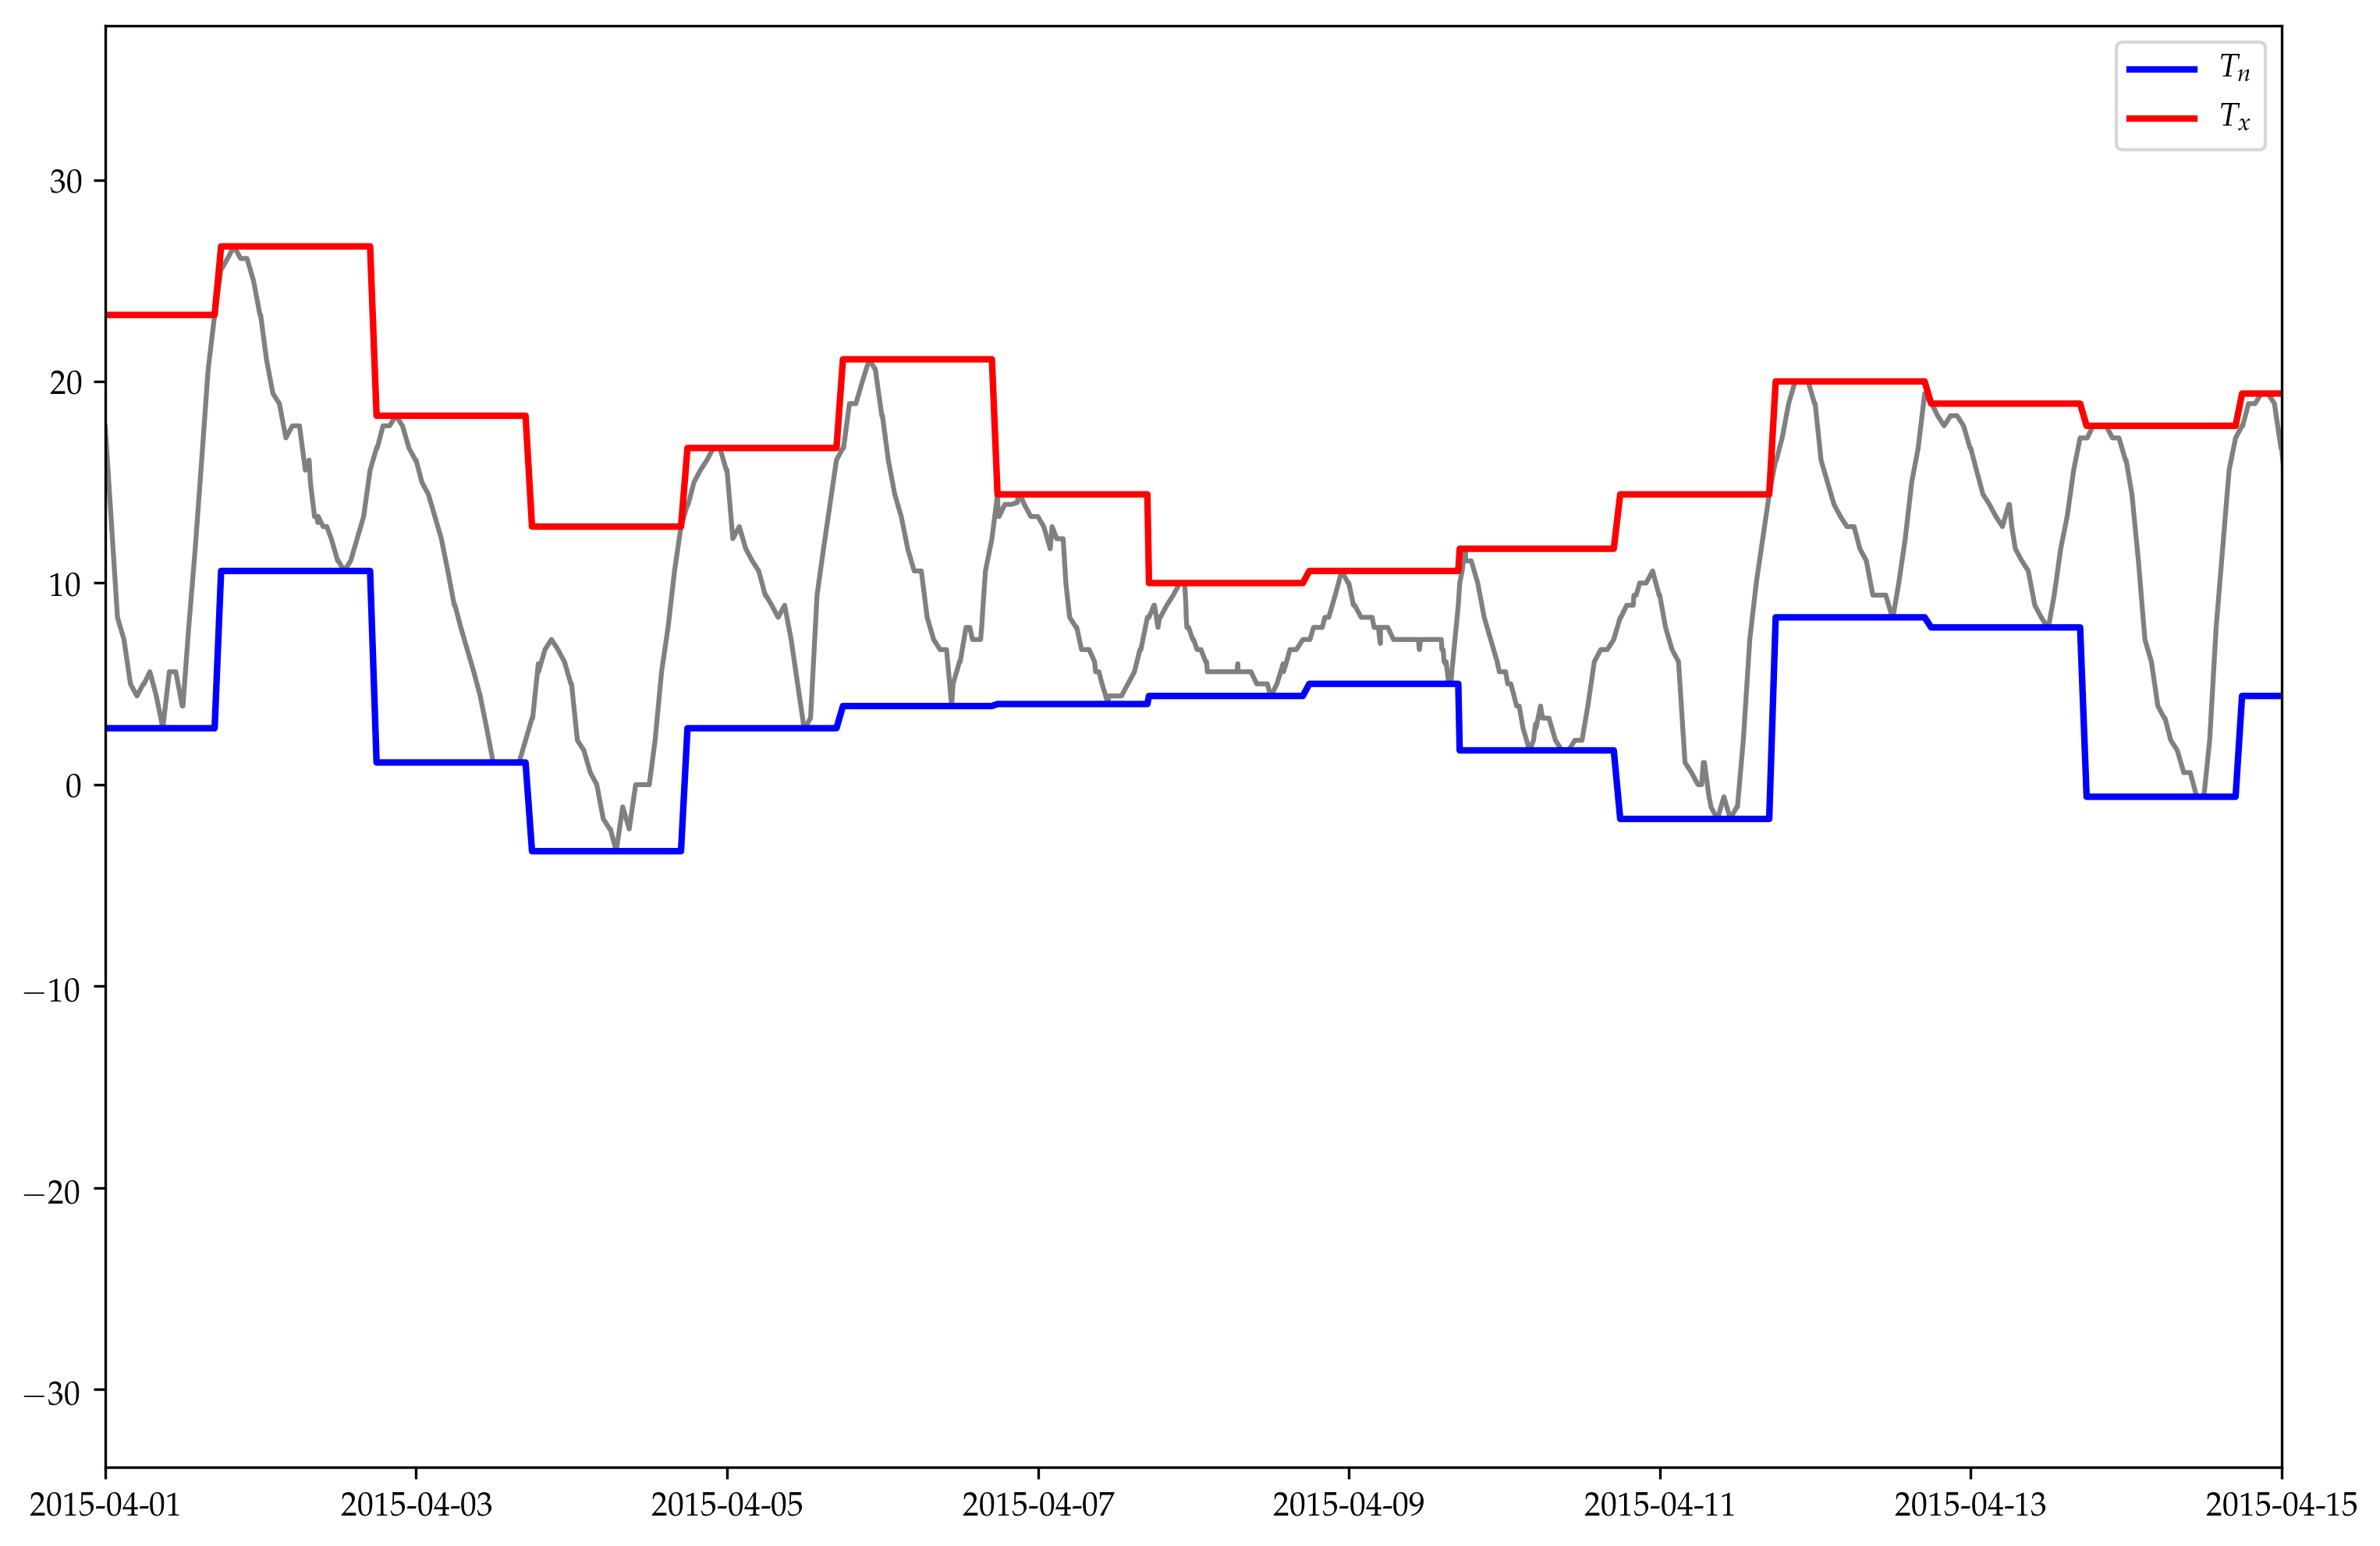

In [38]:
let
    test = iowa[:hourly_test]
    plt.plot(test[:ts], test[:temp], color="grey")
    plt.plot(test[:ts], test[:Tn], color="blue", linewidth=2, label=L"$T_n$")
    plt.plot(test[:ts], test[:Tx], color="red", linewidth=2, label=L"$T_x$")
    plt.xlim(DateTime(2015,4,1),DateTime(2015,4,15)) # random interval
    plt.legend()
end
;

# Kernel Specification

In [39]:
k_spatiotemporal, logNoise = TempModel.fitted_sptemp_SExSE()

(Type: SumKernel{ProdKernel{Masked{SEIso,1},Masked{FixedKernel{SEIso},2}},FixedKernel{Masked{SEIso,2}}}
  Type: ProdKernel{Masked{SEIso,1},Masked{FixedKernel{SEIso},2}}
    Type: Masked{SEIso,1}, Params: [0.996834, 1.3172]    Type: Masked{FixedKernel{SEIso},2}, Params: [12.0805]  Type: FixedKernel{Masked{SEIso,2}}, Params: Float64[], -0.822261)

# Fitting GP on training data

In [40]:
dt_start, dt_end = DateTime(2015,5,25,18,0,0), DateTime(2015,6,3,16,0,0)
train_subset = TempModel.subset(iowa[:hourly_train], dt_start, dt_end)
test_subset  = TempModel.subset(iowa[:hourly_test],  dt_start, dt_end)

avgtemp=by(train_subset, :station, df->DataFrame(avgtemp=mean(df[:temp])))
train_subset = join(train_subset, avgtemp, on=:station)

train_X_PRJ = iowa[:isdSubset][:X_PRJ][train_subset[:station]]
train_Y_PRJ = iowa[:isdSubset][:Y_PRJ][train_subset[:station]]
train_X = [train_subset[:ts_hours] train_X_PRJ train_Y_PRJ]
train_Y = train_subset[:temp] .- train_subset[:avgtemp]

test_X_PRJ = iowa[:isdSubset][:X_PRJ][test_subset[:station]]
test_Y_PRJ = iowa[:isdSubset][:Y_PRJ][test_subset[:station]]
test_X = [test_subset[:ts_hours] test_X_PRJ test_Y_PRJ]
;

In [41]:
train_GP = GP(train_X', train_Y, MeanZero(), k_spatiotemporal, logNoise);

In [42]:
prior_GP = GP(zeros(3,0), zeros(0), MeanZero(), k_spatiotemporal, logNoise);

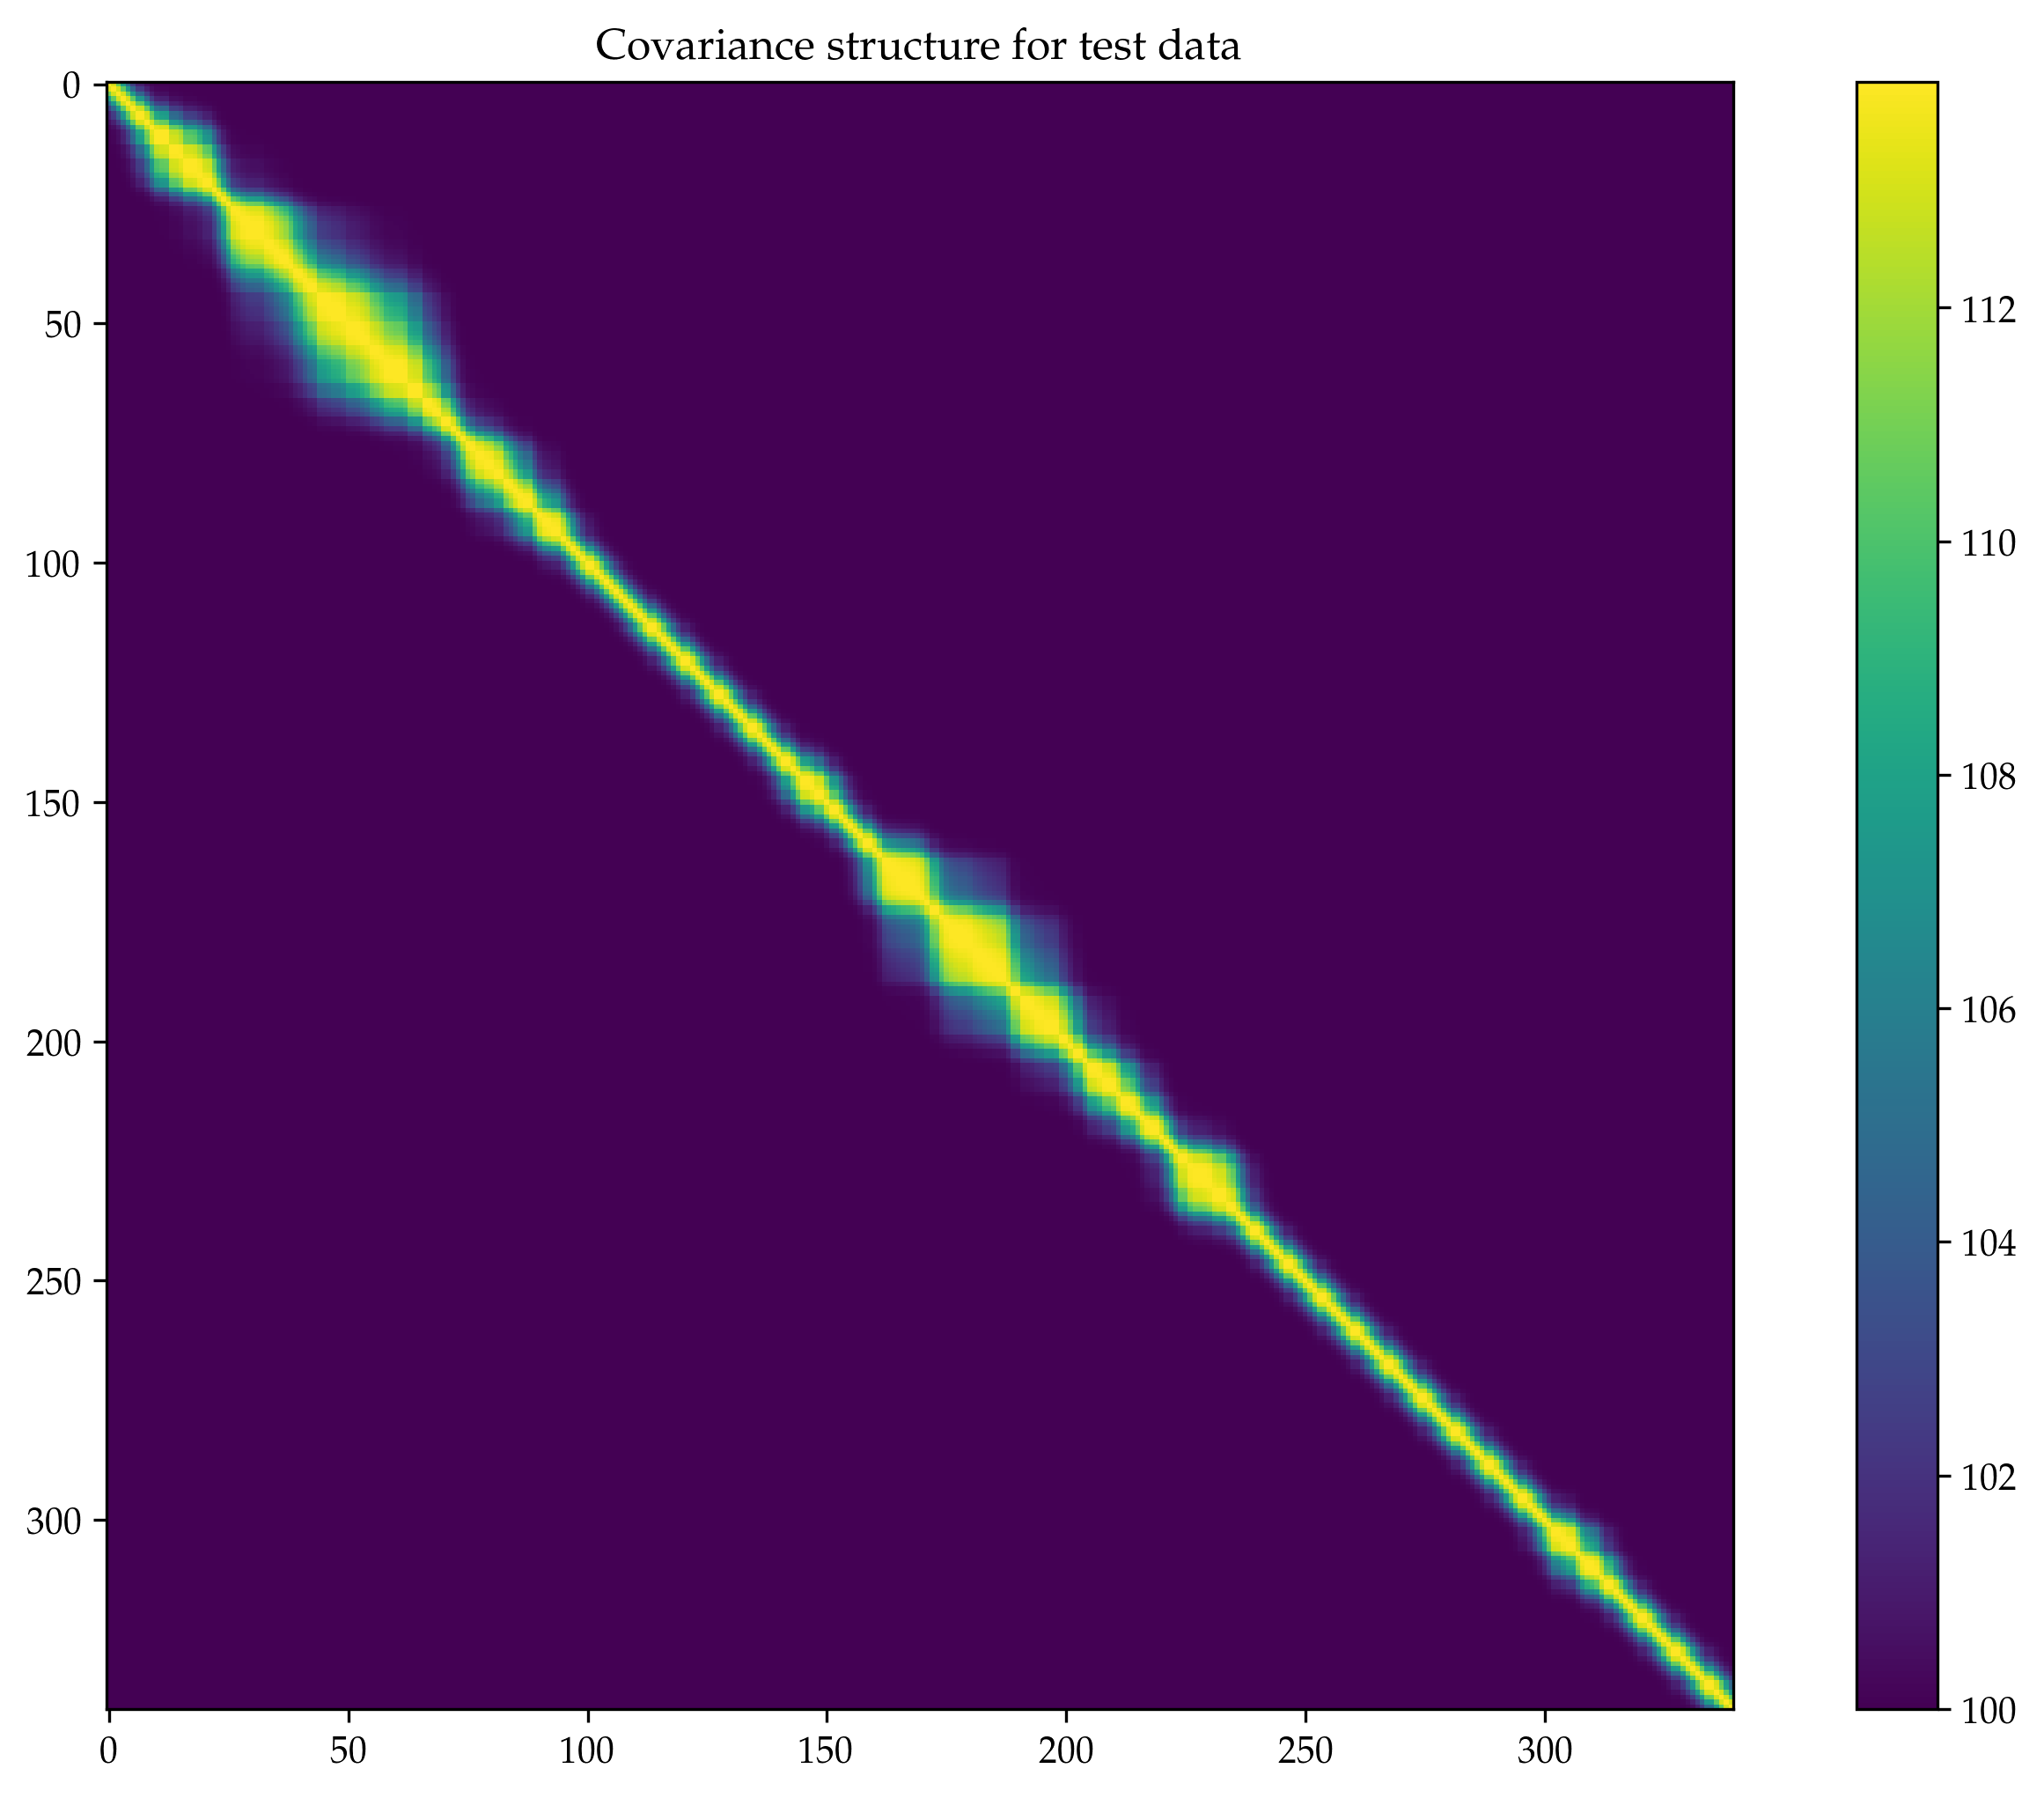

PyObject <matplotlib.colorbar.Colorbar object at 0x136b9e518>

In [43]:
plt.imshow(cov(k_spatiotemporal, test_X'))
plt.title("Covariance structure for test data")
plt.colorbar()

## Predicting at the test location

In [44]:
test_prediction=predict_f(train_GP, test_X'; full_cov=true)
prior_prediction=predict_f(prior_GP, test_X'; full_cov=true)
TempModel.add_diag!(test_prediction[2], exp(2*logNoise))
TempModel.add_diag!(prior_prediction[2], exp(2*logNoise))
;

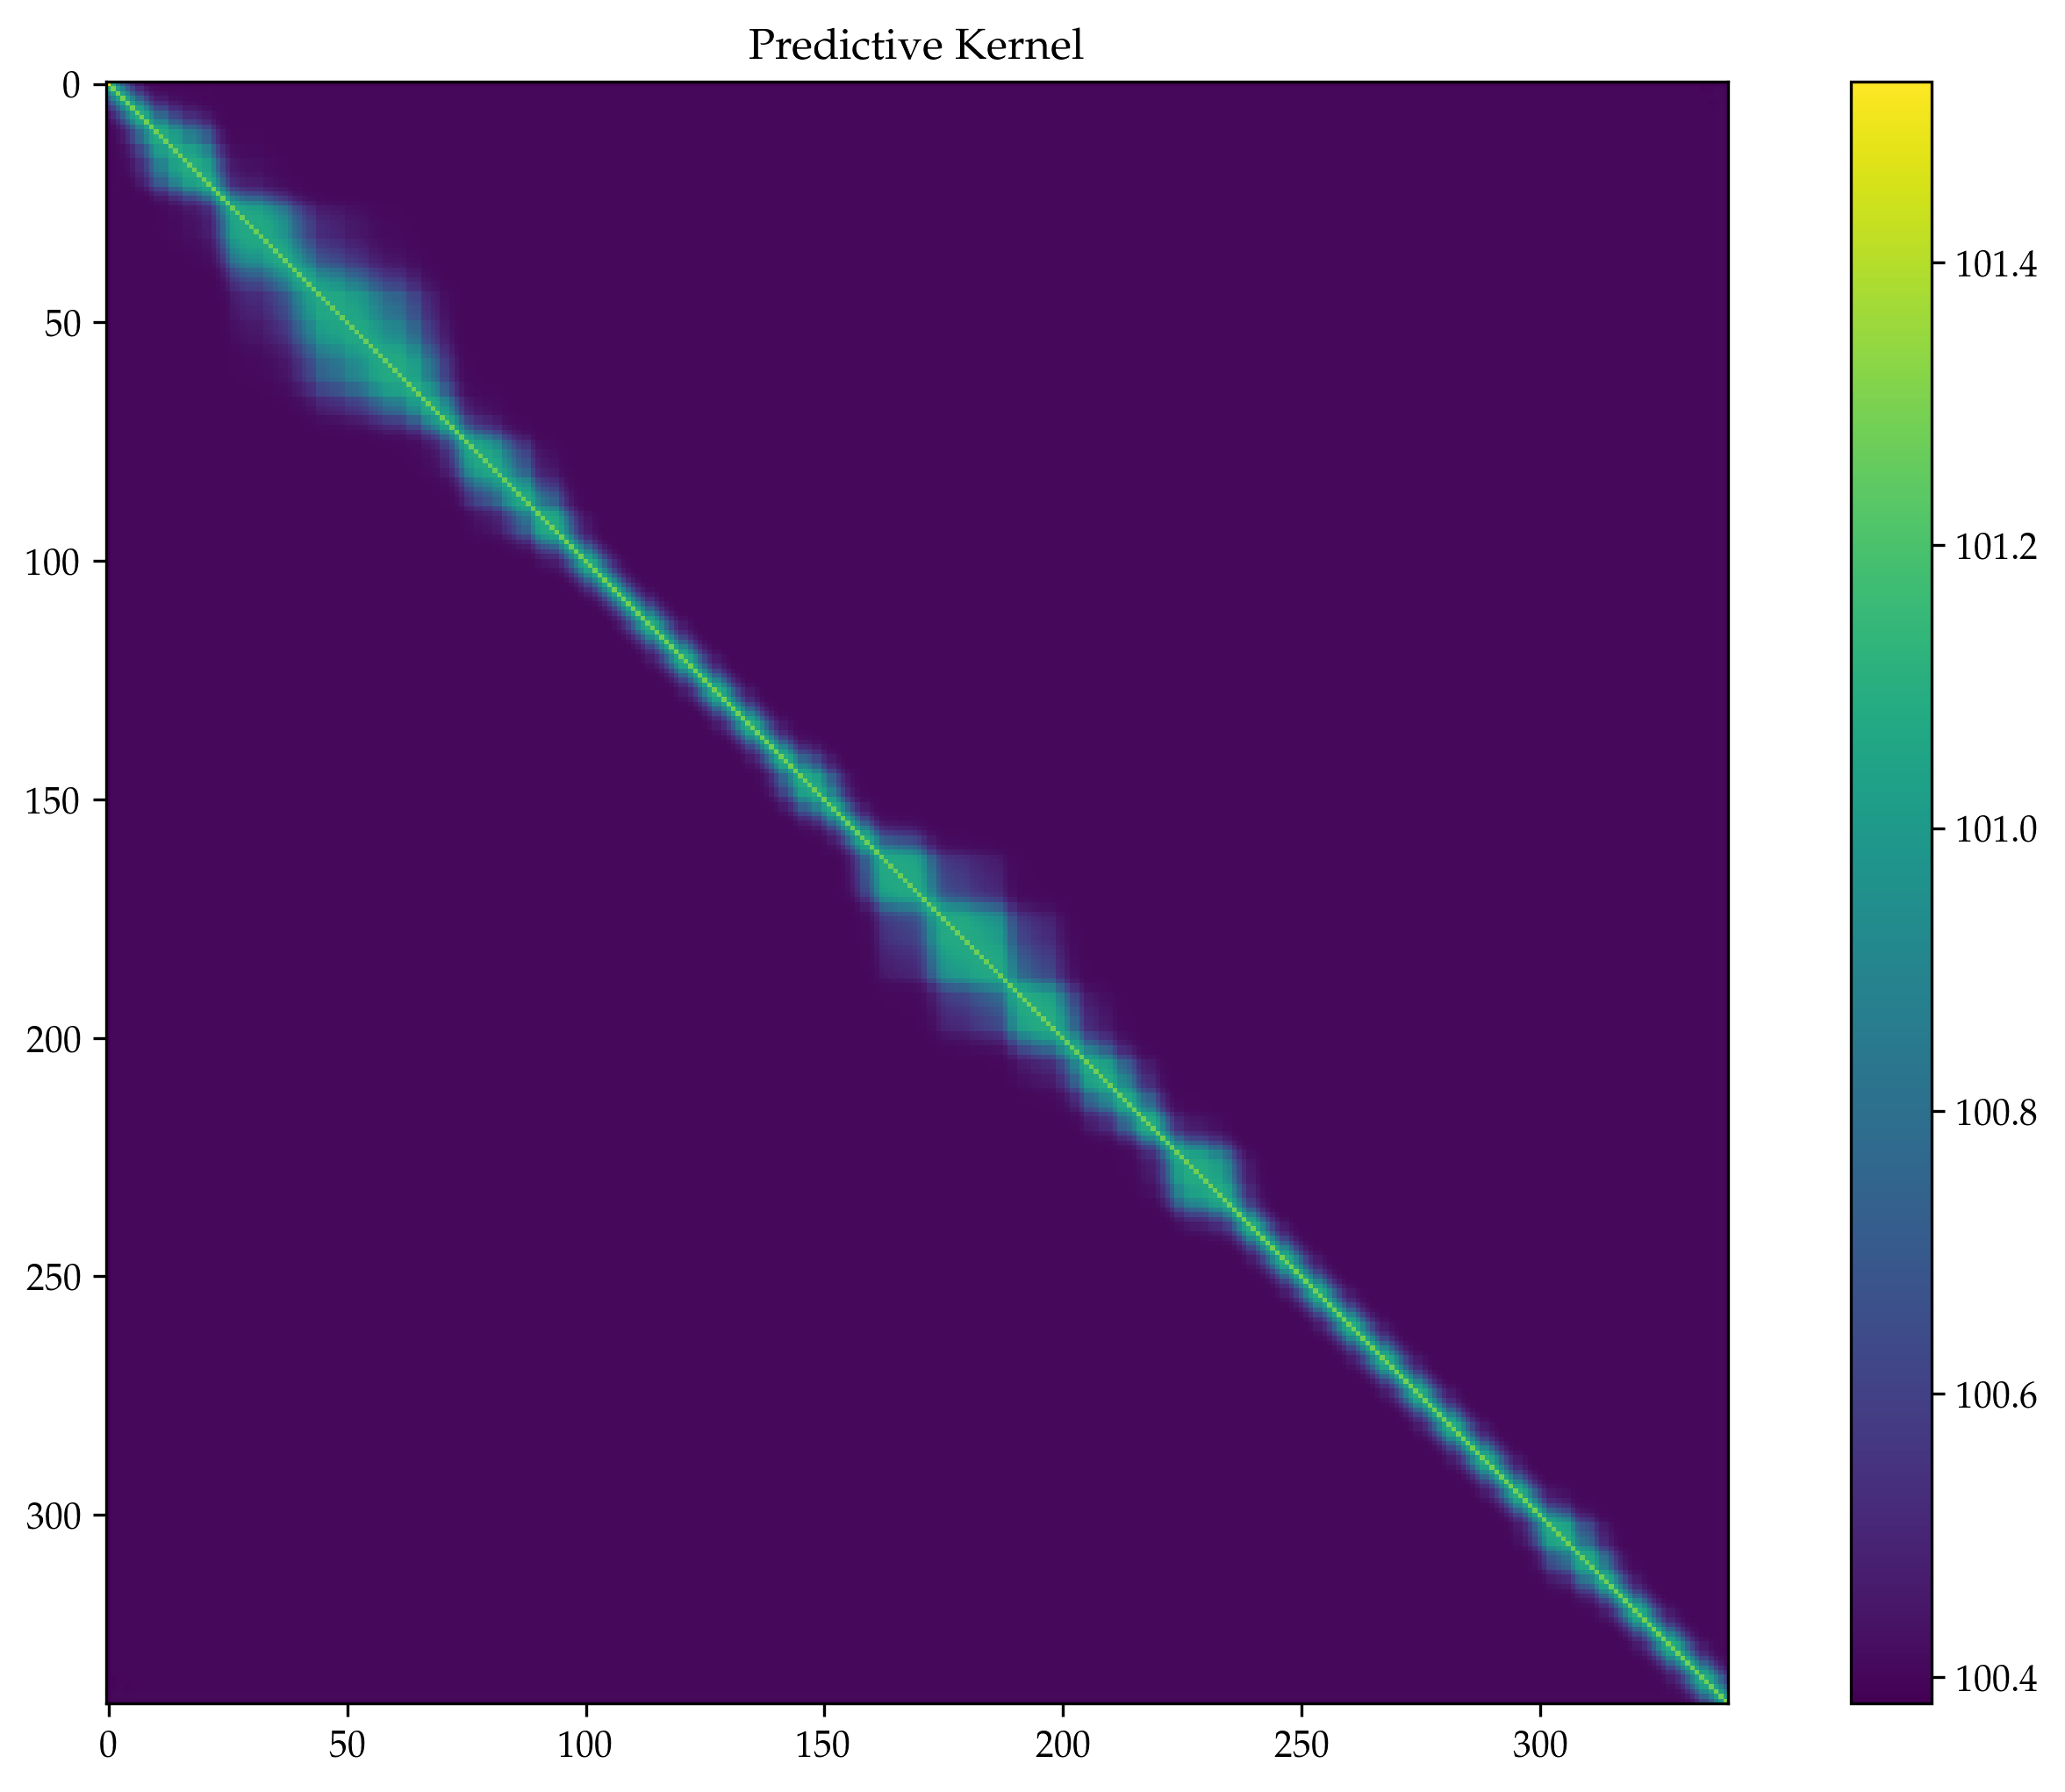

PyObject <matplotlib.colorbar.Colorbar object at 0x127fc4160>

In [45]:
begin
    plt.imshow(test_prediction[2].mat)
    plt.title("Predictive Kernel")
    plt.colorbar()
end

## Predictive draws

Let's show some draws from the posterior fitted using the hourly data at nearby stations, but *not* the $T_n$ and $T_x$ records.

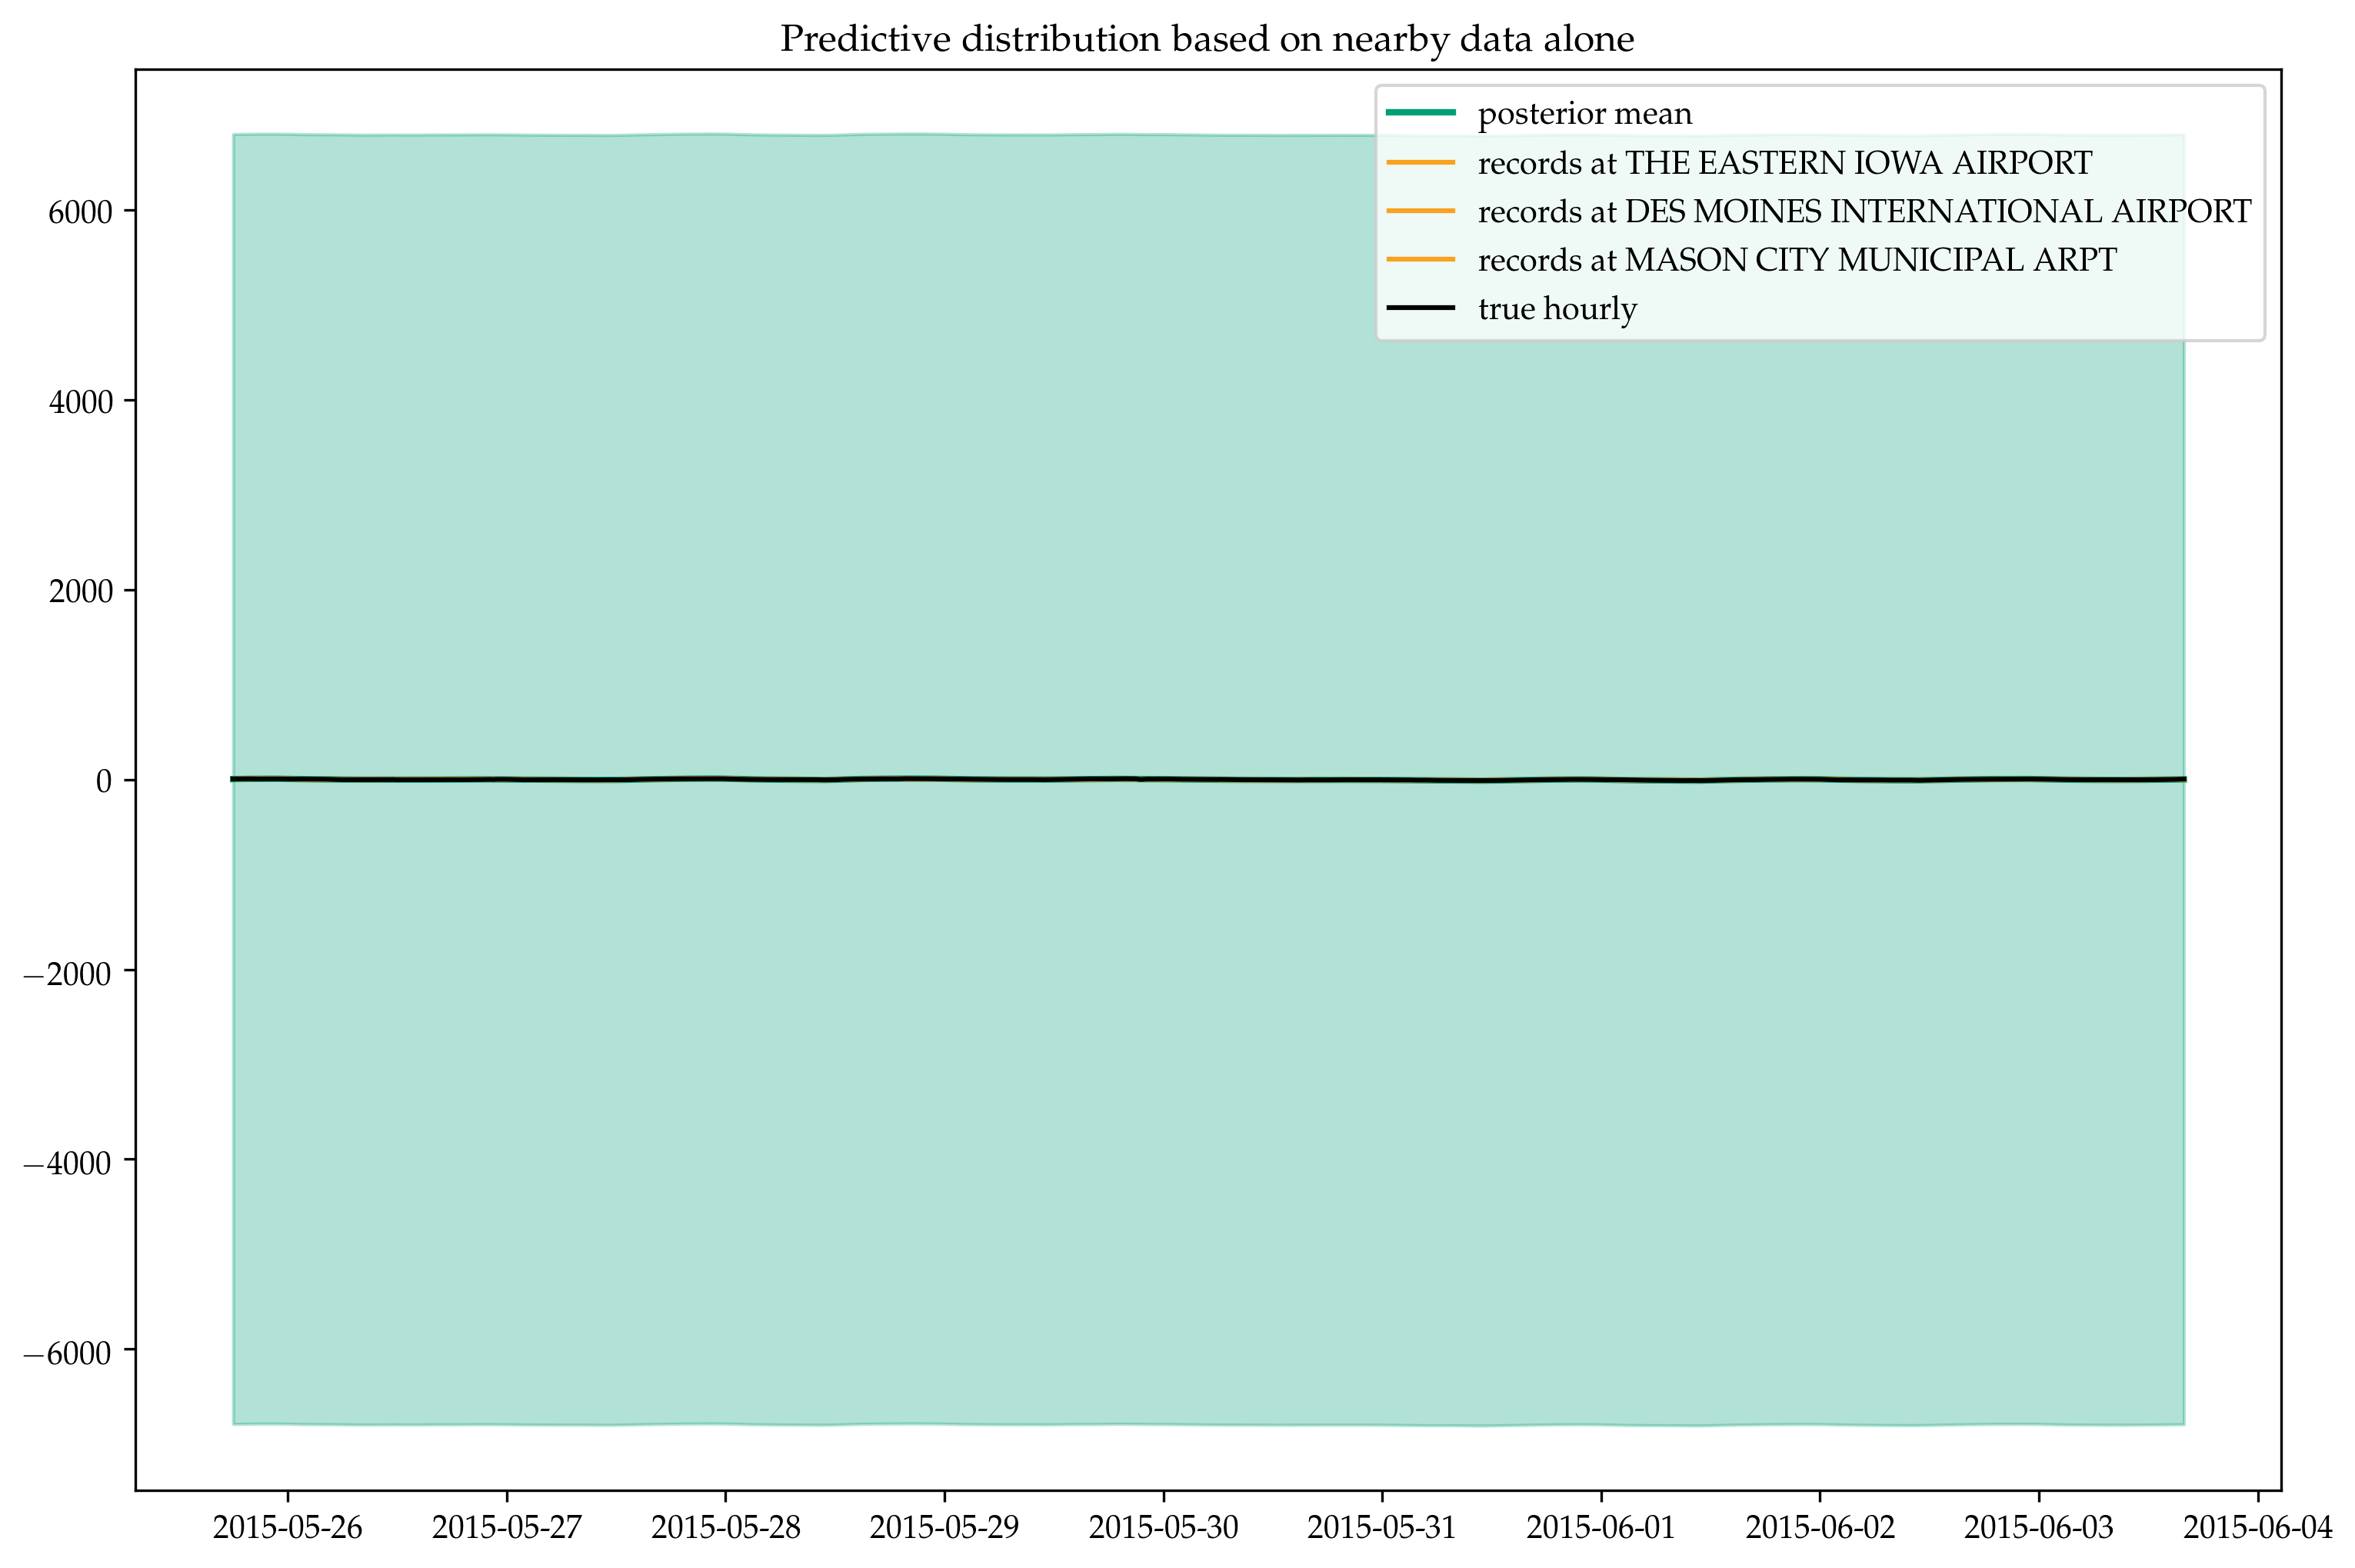

  likely near /Users/imolk/Library/Julia/packages/IJulia/nBp96/src/kernel.jl:41
  likely near /Users/imolk/Library/Julia/packages/IJulia/nBp96/src/kernel.jl:41
  likely near /Users/imolk/Library/Julia/packages/IJulia/nBp96/src/kernel.jl:41
in top-level scope at none


In [46]:
begin
    ts=test_subset[:ts]
    μ = test_prediction[1]
    Σ = test_prediction[2]
    nobsv = length(μ)
    
    centering = I .- (1.0/nobsv) .* ones(nobsv, nobsv)
    Σ_centered = centering * Σ.mat * centering
    distr = MultivariateNormal(μ, Σ)
    plt.plot(ts, μ, color="#009F77", linewidth=2, label="posterior mean")
    for _ in 1:5
        temp_sim = rand(distr)
        plt.plot(ts, temp_sim.-mean(temp_sim), color="#009F77", linewidth=1)
    end
    y_err = sqrt.(diag(Σ_centered))
    plt.fill_between(ts, μ-2*y_err,μ+2*y_err, color="#009F77", alpha=0.3)
    for station in unique(train_subset[:station])
        sdata = train_subset[train_subset[:station].==station,:]
        ts=sdata[:ts]
        plt.plot(ts, sdata[:temp].-mean(sdata[:temp]), color="#F8A21F", 
            label=string("records at", " ", iowa[:isdSubset][station,:NAME]))
    end
    ts = test_subset[:ts]
    temp_true = test_subset[:temp]
    plt.plot(ts, temp_true.-mean(temp_true), 
        color="black", "-", label="true hourly")
    plt.legend(loc="best")
    plt.title("Predictive distribution based on nearby data alone")
end
;

It's interesting to note that the posterior mean is quite close to the truth, despite the very wide credible envelope. To me this suggests that the information available from nearby stations is underweighted. We should be making more confident predictions.

# Specifying STAN model

In [47]:
imputation_model = TempModel.get_imputation_model()
;

=====> /Users/imolk/Documents/Harvard/Natesh/temperature_model/notebooks


File /Users/imolk/Documents/Harvard/Natesh/temperature_model/notebooks/tmp/imputation.stan will be updated.



## preparing Stan data

In [48]:
test_TxTn = by(test_subset, :ts_day, df -> DataFrame(
    Tn=first(df[:Tn]), 
    Tx=first(df[:Tx]), 
    times_p_day=nrow(df),
))

,ts_day,Tn,Tx,times_p_day
,Date,Float64,Float64,Int64
1,2015-05-26,15.6,25.6,46
2,2015-05-27,13.9,22.8,54
3,2015-05-28,13.9,26.7,27
4,2015-05-29,16.7,27.2,31
5,2015-05-30,12.8,26.7,59
6,2015-05-31,6.7,16.1,36
7,2015-06-01,6.7,19.4,28
8,2015-06-02,10.0,21.7,32
9,2015-06-03,15.0,23.9,27


In [121]:
ts_day = test_subset[:ts_day]
day_impute = Int.( (ts_day .- minimum(ts_day)) ./ Day(1) ) .+ 1
imputation_data = Dict(
    "N_TxTn" => nrow(test_TxTn),
    "Tn" => test_TxTn[:Tn],
    "Tx" => test_TxTn[:Tx],
    "Nimpt" => nrow(test_subset),
    "day_impute" => day_impute,
    "impt_times_p_day" => test_TxTn[:times_p_day],
    "predicted_mean" => test_prediction[1],
    "predicted_cov" => test_prediction[2].mat,
    "predicted_cov_chol" => Matrix(test_prediction[2].chol.L),
    "k_smoothmax" => 20.0,
    "epsilon" => 0.01,
    
)

Dict{String,Any} with 11 entries:
  "impt_times_p_day"   => [46, 54, 27, 31, 59, 36, 28, 32, 27]
  "Tx"                 => [25.6, 22.8, 26.7, 27.2, 26.7, 16.1, 19.4, 21.7, 23.9]
  "predicted_mean"     => [5.13125, 6.48652, 7.66563, 8.52217, 8.97763, 8.71282…
  "predicted_cov_chol" => [10.0761 0.0 … 0.0 0.0; 10.032 0.809554 … 0.0 0.0; … …
  "Nimpt"              => 340
  "day_impute"         => [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  9, 9, 9, 9, 9, 9, 9…
  "predicted_cov"      => [101.528 101.084 … 100.388 100.381; 101.084 101.297 ……
  "k_smoothmax"        => 20.0
  "epsilon"            => 0.01
  "Tn"                 => [15.6, 13.9, 13.9, 16.7, 12.8, 6.7, 6.7, 10.0, 15.0]
  "N_TxTn"             => 9

# Running STAN

In [122]:
@time sim1 = stan(imputation_model, [imputation_data], summary=false, diagnostics=false);


make: `/Users/imolk/Documents/Harvard/Natesh/temperature_model/notebooks/tmp/imputation' is up to date.

Length of data array is not equal to nchains,
all chains will use the first data dictionary.


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite!  (in '/Users/imolk/Documents/Harvard/Natesh/temperature_model/notebooks/tmp/imputation.stan' at line 60)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite!  (in '/Users/imolk/Documents/Harvard/Natesh/temperature_model/notebooks/tmp/imputation.stan' at line 60)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite!  (in '/Users/imolk/Documents/Harvard/Natesh/temperature_model/notebooks/tmp/imputation.stan' at line 60)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite!  (in '/Users/imolk/Documents/Harvard/Natesh/temperature_model/notebooks/tmp/imputation.stan' at line 60)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your

but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite!  (in '/Users/imolk/Documents/Harvard/Natesh/temperature_model/notebooks/tmp/imputation.stan' at line 60)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite!  (in '/Users/imolk/Documents/Harvard/Natesh/temperature_model/notebooks/tmp/imputation.stan' at line 60)

If this warning occurs sporadically, such as for highly constrained var

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite!  (in '/Users/imolk/Documents/Harvard/Natesh/temperature_model/notebooks/tmp/imputation.stan' at line 60)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite!  (in '/Users/imolk/Documents/Harvard/Natesh/temperature_model/notebooks/tmp/imputation.stan' at line 60)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your

1068.215613 seconds (18.05 M allocations: 828.944 MiB, 0.04% gc time)


In [123]:
using MCMCChain
chains=Chains(sim1[2]; names=sim1[3]);

In [124]:
gelmandiag(chains)

                    PSRF           97.5%    
         lp__   1.0010000×10⁰   1.003000×10⁰
accept_stat__   1.0040000×10⁰   1.008000×10⁰
   stepsize__ 4.73732669×10¹² 9.5992918×10¹²
  treedepth__             NaN            NaN
 n_leapfrog__             NaN            NaN
  divergent__             NaN            NaN
     energy__   1.0000000×10⁰   1.002000×10⁰
   w_uncorr.1   1.0110000×10⁰   1.032000×10⁰
   w_uncorr.2   1.0050000×10⁰   1.013000×10⁰
   w_uncorr.3   1.0110000×10⁰   1.035000×10⁰
   w_uncorr.4   1.0010000×10⁰   1.004000×10⁰
   w_uncorr.5   1.0040000×10⁰   1.013000×10⁰
   w_uncorr.6   1.0060000×10⁰   1.019000×10⁰
   w_uncorr.7   1.0010000×10⁰   1.003000×10⁰
   w_uncorr.8   1.0010000×10⁰   1.002000×10⁰
   w_uncorr.9   1.0100000×10⁰   1.030000×10⁰
  w_uncorr.10   1.0050000×10⁰   1.016000×10⁰
  w_uncorr.11   1.0080000×10⁰   1.025000×10⁰
  w_uncorr.12   1.0020000×10⁰   1.007000×10⁰
  w_uncorr.13   1.0030000×10⁰   1.011000×10⁰
  w_uncorr.14   1.0030000×10⁰   1.008000×10⁰
  w_uncorr

In [125]:
traceplot(chains)

MethodError: MethodError: no method matching plot(::Chains{Float64}; seriestype=:traceplot)
Closest candidates are:
  plot(::MCMCChain.AbstractChains, !Matched::Array{Symbol,1}; args...) at /Users/imolk/Library/Julia/packages/MCMCChain/suohp/src/plot.jl:125
  plot(::MCMCChain.AbstractChains, !Matched::Symbol; args...) at /Users/imolk/Library/Julia/packages/MCMCChain/suohp/src/plot.jl:131

In [126]:
using AxisArrays
function Chains(samples::AbstractArray{Float64, 3}, names::AbstractVector{S}) where {S<:AbstractString}
    nsamples, ncol, nchains = size(samples)
    chains = AxisArray(samples, Axis{:sample}(1:nsamples), Axis{:param}(names), Axis{:chain}(1:nchains))
    return chains
end
function get_param_names(chains::AxisArray)
    # there should be a more elegant way to obtain the names of an axis
    PARAM = Axis{:param}
    jparam = axisdim(chains, PARAM)
    param_axis = AxisArrays.axes(chains)[jparam]
    param_names = axisvalues(param_axis)[1]
    return param_names
end
function get_temperatures_reparam(chains::AxisArray)
    # next 4 lines: tedious way to get names of parameters
    param_names = get_param_names(chains)
    temp_varnames = [h for h in param_names if startswith(h, "temp_impt.")]
    temp_samples = view(chains, :, Axis{:param}(temp_varnames), :)
    return temp_samples
end
chains = Chains(sim1[2], sim1[3])
size(chains)

(1000, 705, 4)

In [127]:
temp_impute = get_temperatures_reparam(chains); # extract imputed temperatures

# Plotting

In [128]:
stacked_impute=vcat((temp_impute[:,:,i] for i in 1:size(temp_impute,3))...)
sorted_impute = sort(stacked_impute, dims=1);
nsamples=size(sorted_impute,1)
# extract and 2.5th and 97.5th percentiles
# of the imputations
imputed_025 = sorted_impute[div(nsamples,40), :]
imputed_975 = sorted_impute[nsamples-div(nsamples,40), :]
;

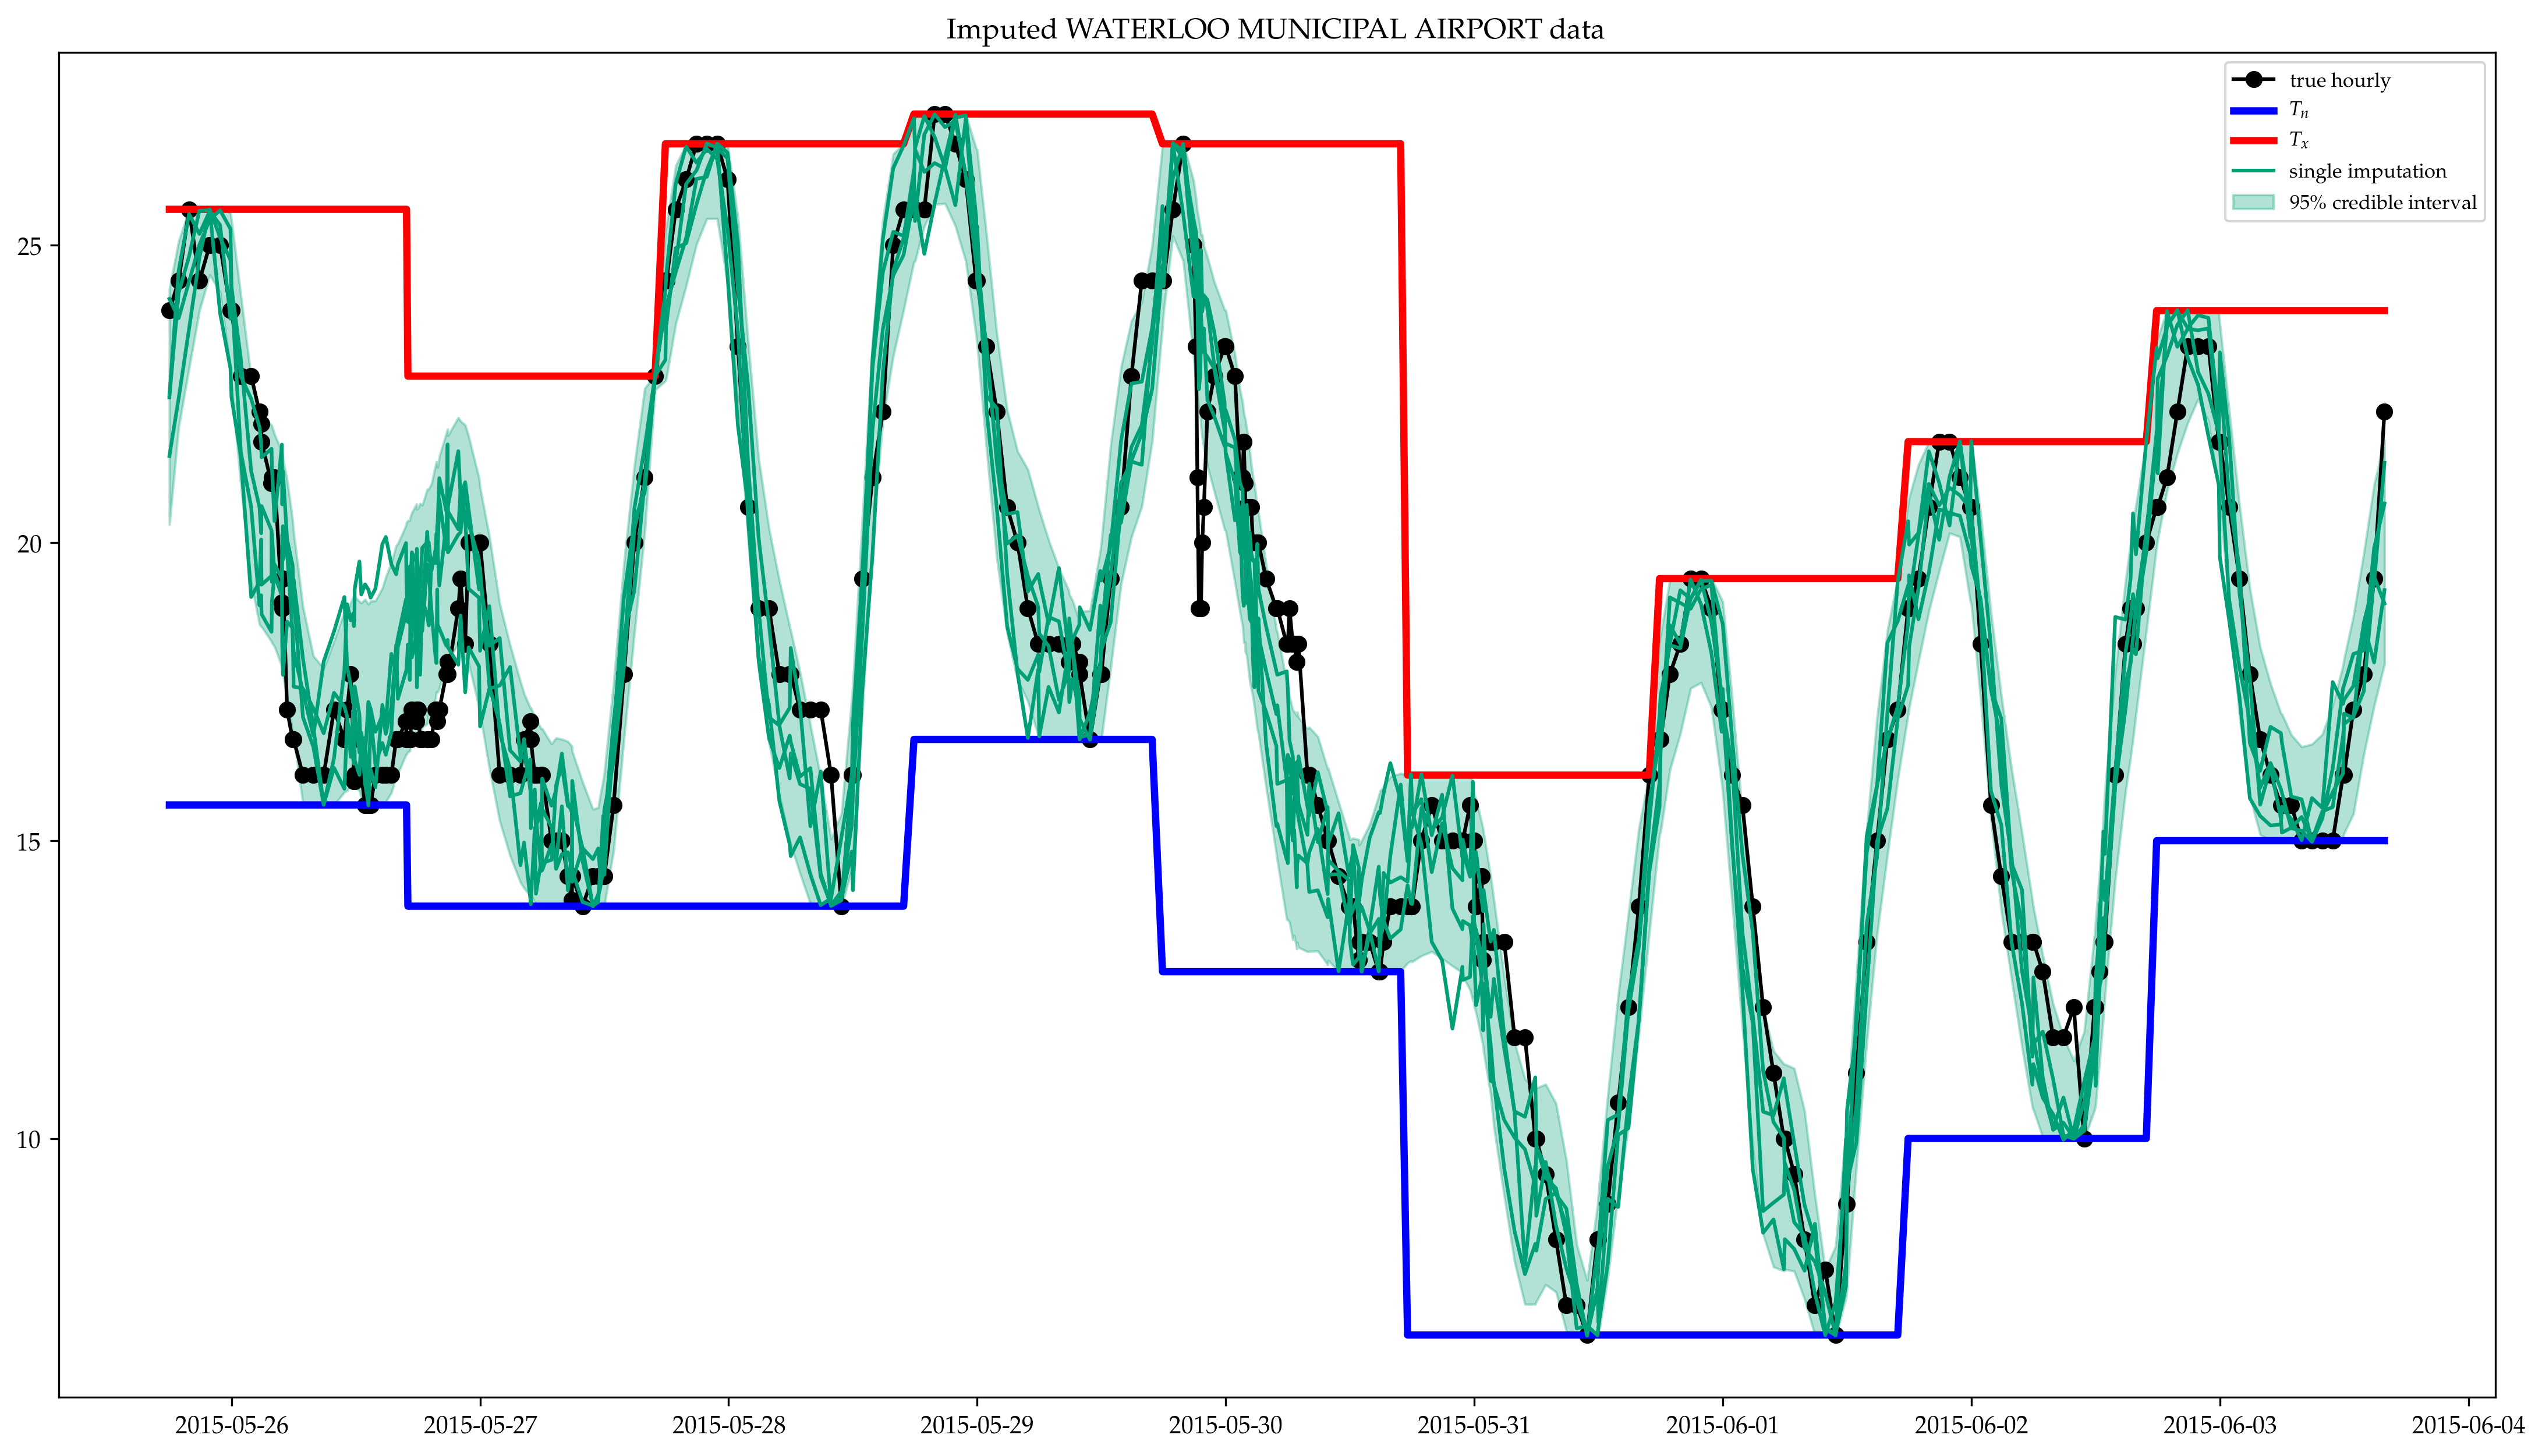

In [129]:
begin
    ts = test_subset[:ts]
    plt.plot(ts, test_subset[:temp], 
        color="black", "o-", label="true hourly")
    plt.plot(ts, test_subset[:Tn], 
        color="blue", linewidth=3, label=L"$T_n$")
    plt.plot(ts, test_subset[:Tx], 
        color="red", linewidth=3, label=L"$T_x$")
    plt.fill_between(ts, imputed_025, imputed_975, 
        color="#009F77", alpha=0.3, label=L"$95\%$ credible interval")
    plt.plot(ts, temp_impute[250,:,1],
        color="#009F77", label="single imputation")
    for i in 2:size(temp_impute,3)
        plt.plot(ts, temp_impute[250,:,i], color="#009F77")
    end
    plt.legend(loc="best", fontsize="small")
    plt.gcf()[:set_size_inches](18.0, 10.0)
    plt.title(@sprintf("Imputed %s data", iowa[:isdSubset][iowa[:itest],:NAME]))
end
;

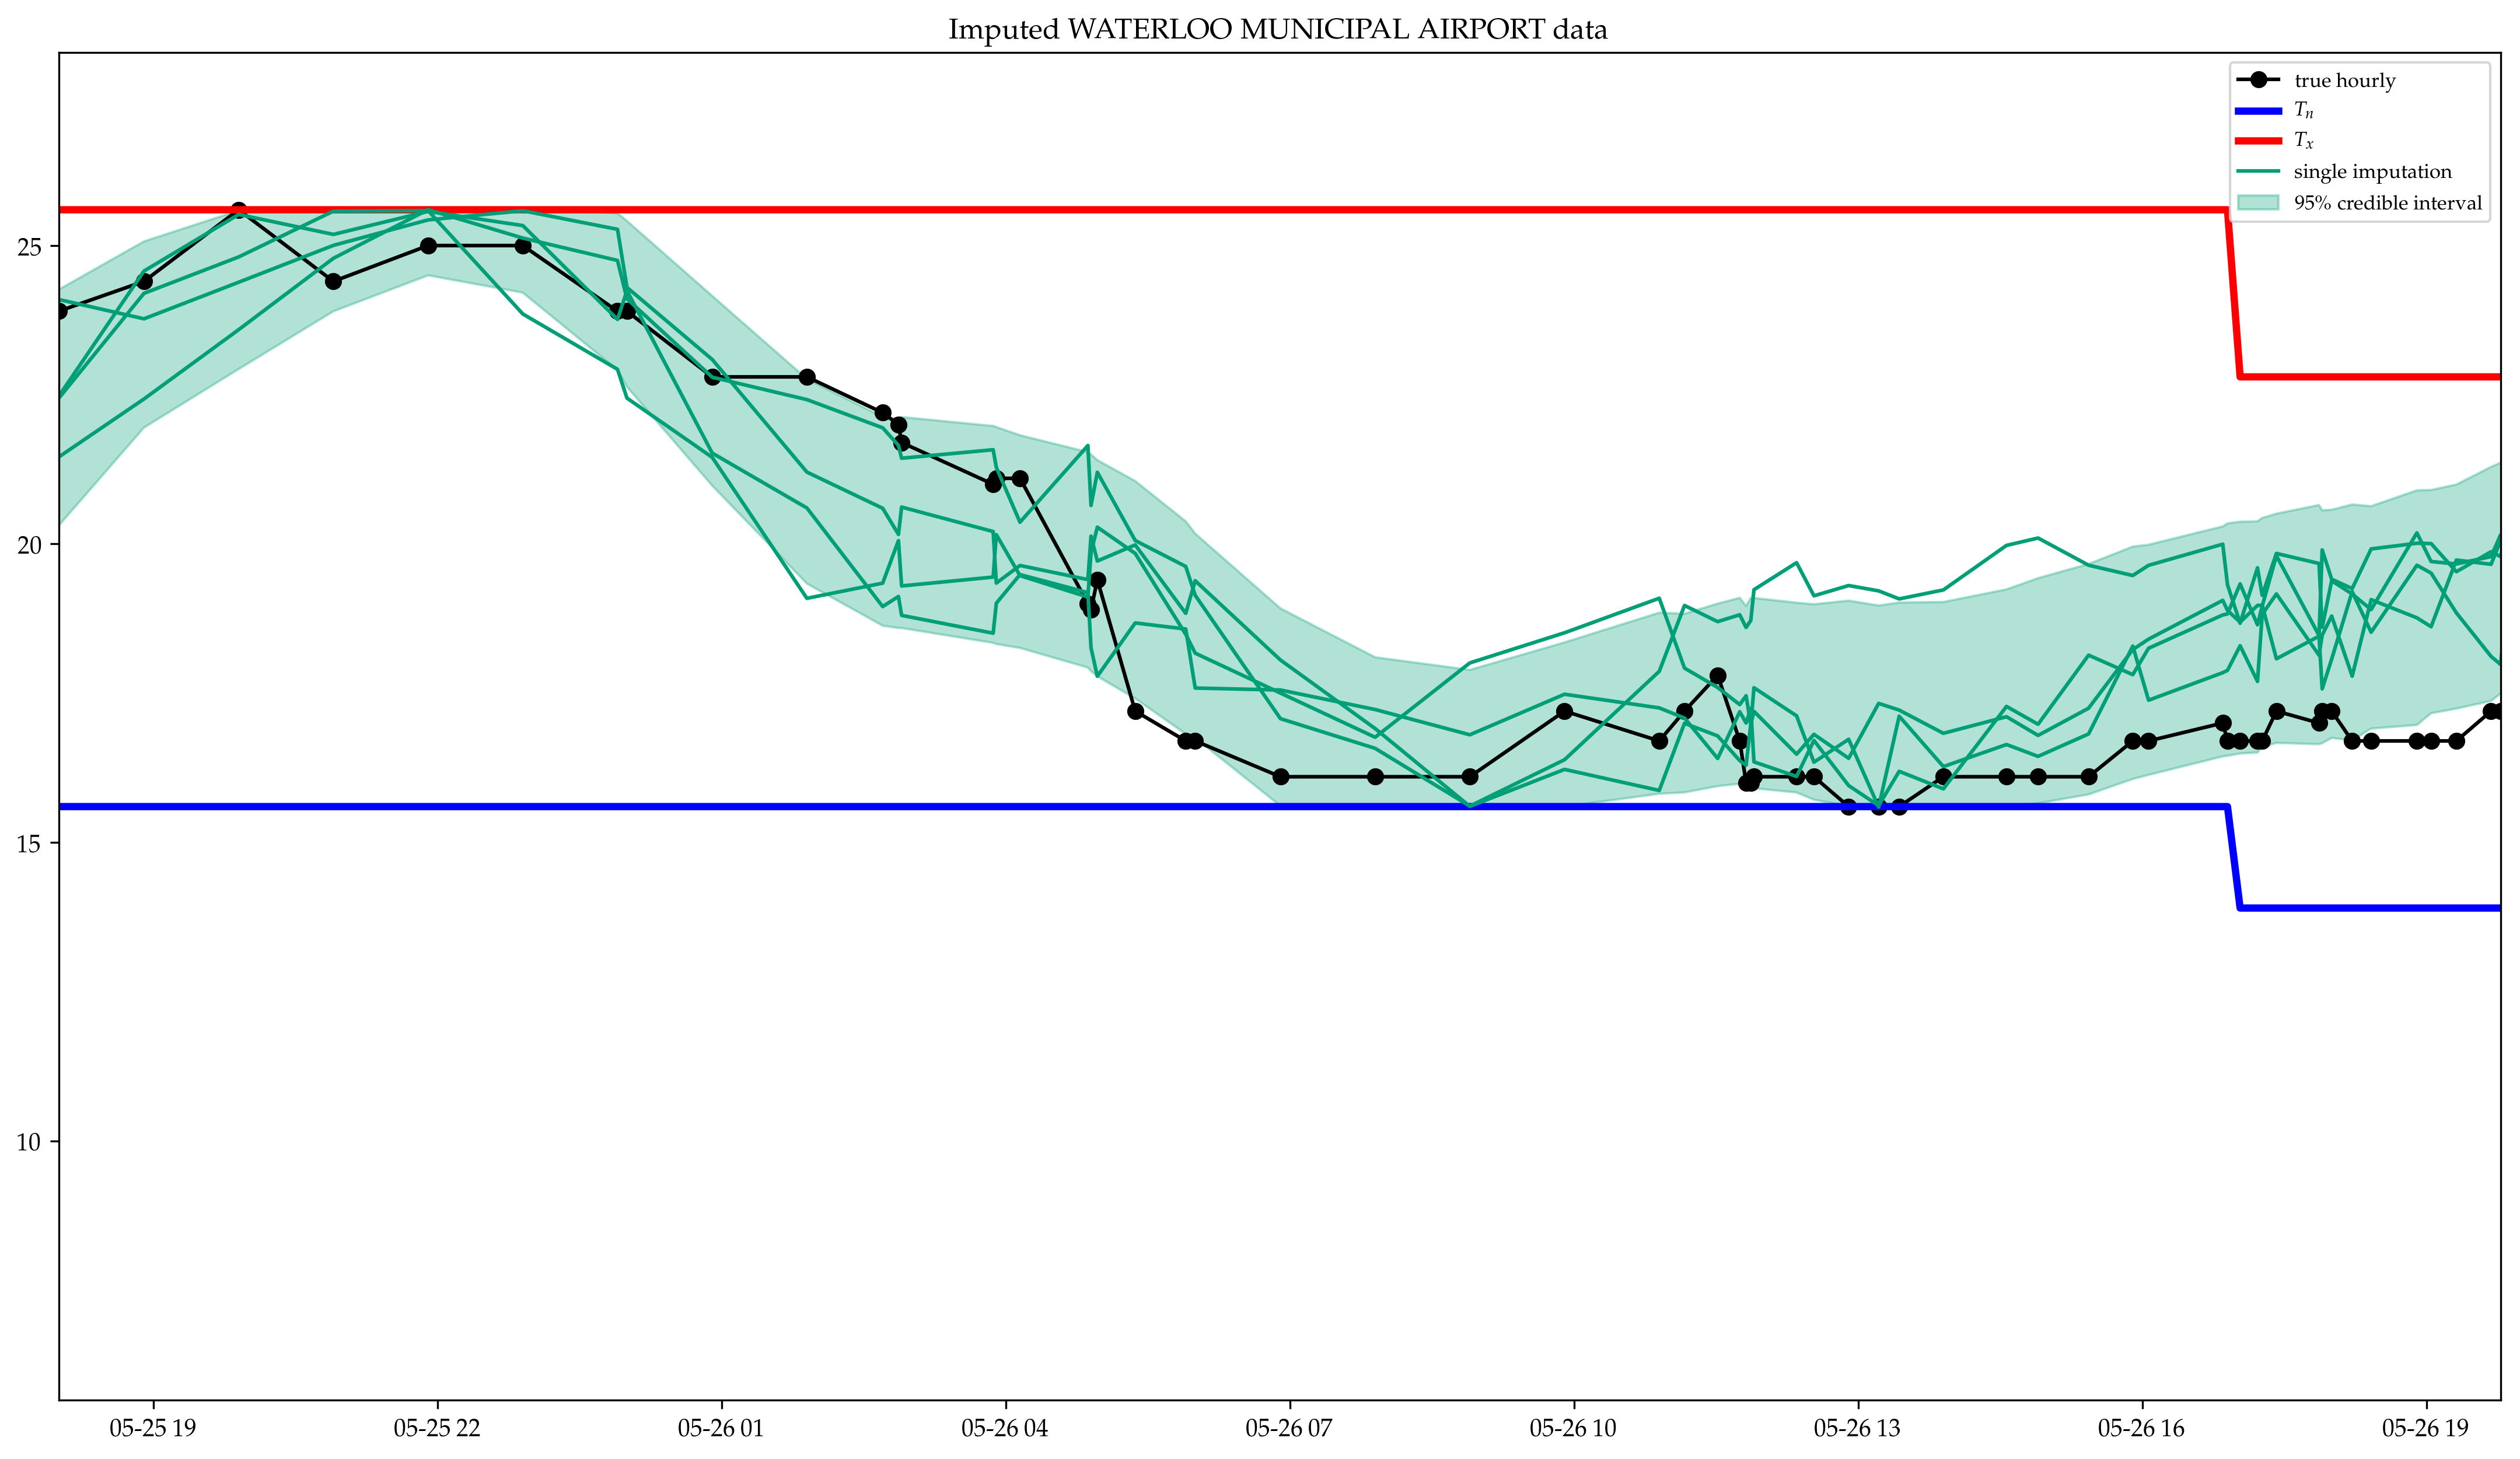

In [130]:
begin
    ts = test_subset[:ts]
    plt.plot(ts, test_subset[:temp], 
        color="black", "o-", label="true hourly")
    plt.plot(ts, test_subset[:Tn], 
        color="blue", linewidth=3, label=L"$T_n$")
    plt.plot(ts, test_subset[:Tx], 
        color="red", linewidth=3, label=L"$T_x$")
    plt.fill_between(ts, imputed_025, imputed_975, 
        color="#009F77", alpha=0.3, label=L"$95\%$ credible interval")
    plt.plot(ts, temp_impute[250,:,1],
        color="#009F77", label="single imputation")
    for i in 2:size(temp_impute,3)
        plt.plot(ts, temp_impute[250,:,i], color="#009F77")
    end
    plt.legend(loc="best", fontsize="small")
    plt.gcf()[:set_size_inches](18.0, 10.0)
    plt.title(@sprintf("Imputed %s data", iowa[:isdSubset][iowa[:itest],:NAME]))
    plt.xlim(ts[1], ts[60])
end
;

# Observations

Note that we've separated the imputation procedure into two separate steps, which use two separate sources of information about the temperatures:

1. the hourly temperatures at nearby stations
2. the $T_n$ and $T_x$ records at the test station

The advantage is that incorporating the nearby hourly temperatures can be done analytically once we specify a Gaussian Process model. So that step is computationally very quick. We then only use SmoothHMC in Stan to add the second source of information. 
The STAN model is therefore hugely simplified, and the fitting time is greatly reduced.

We're getting good convergence diagnostics from Stan, and the imputed temperatures:
1. stay within the constraints imposed by $T_n$ and $T_x$
2. are very close to the true temperatures at Waterloo Municipal Airport
3. on May 27th and 28th the model accurately finds that the high for both days is set in the same afternoon, and that the peak of the previous diurnal cycle does not get recorded

Sources of worry are:
* the imputed temperatures look a bit noisy: less smooth than the true temperature time series;
* the true temperatures sometimes drift out of the 95% envelope, though not necessarily more often than they should.